In [1]:
%matplotlib inline

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
import tensorflow as tf; tf.__version__

'1.12.0'

In [12]:
from pathlib import Path; Path.ls = lambda x: list(x.iterdir())

In [13]:
path = Path('.'); path.ls()

[PosixPath('deeplabv3_257_mv_gpu.tflite'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('deeplabv3_mnv2_dm05_pascal_trainaug'),
 PosixPath('Deeplab Semantic Segmentation.ipynb')]

In [14]:
(path/'deeplabv3_mnv2_dm05_pascal_trainaug/').ls()

[PosixPath('deeplabv3_mnv2_dm05_pascal_trainaug/frozen_inference_graph.pb'),
 PosixPath('deeplabv3_mnv2_dm05_pascal_trainaug/model.ckpt.data-00000-of-00001'),
 PosixPath('deeplabv3_mnv2_dm05_pascal_trainaug/model.ckpt.index')]

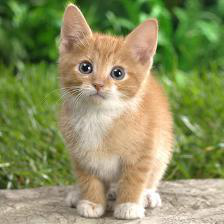

In [15]:
# example image
import  PIL
from PIL import Image
img = PIL.Image.open('../../cat224x224.jpg'); img

In [16]:
img = img.resize((257, 257))
input_data = np.array(np.asarray(img)[None,:], dtype=np.float32)/255

In [17]:
np.asarray(img).shape

(257, 257, 3)

### Test tflite model

In [18]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.contrib.lite.Interpreter(model_path=str(path/'deeplabv3_257_mv_gpu.tflite'))
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']

# change the following line to feed into your own data.
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()
tflite_output = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

In [38]:
input_details

[{'name': 'sub_7',
  'index': 183,
  'shape': array([  1, 257, 257,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [39]:
output_details

[{'name': 'ResizeBilinear_3',
  'index': 168,
  'shape': array([  1, 257, 257,  21], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0)}]

In [19]:
input_data.shape, tflite_output.shape

((1, 257, 257, 3), (1, 257, 257, 21))

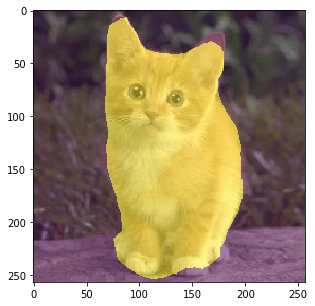

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(input_data[0])
ax.imshow(np.argmax(tflite_output[0], -1), alpha=0.5)

### Load Frozen Graph

In [42]:
#Load the new optimized graph and check whether the output is consistent,
tf.reset_default_graph()
with tf.gfile.GFile('../segmentation/deeplabv3_mnv2_dm05_pascal_trainaug/frozen_inference_graph.pb'
                    , 'rb') as f:
    graph_def_optimized = tf.GraphDef()
    graph_def_optimized.ParseFromString(f.read())

G = tf.Graph()

with tf.Session(graph=G) as sess:
    
    image_tensor = tf.import_graph_def(graph_def_optimized, return_elements=['ImageTensor:0'])
    print('Operations in Optimized Graph:')
    print([op.name for op in G.get_operations()]) 
#     x = G.get_tensor_by_name('import/import/input:0')
#     print(sess.run([boxes, scores, classes], feed_dict={x: np.expand_dims(img, 0)}))

Operations in Optimized Graph:
['import/ImageTensor', 'import/Shape', 'import/strided_slice/stack', 'import/strided_slice/stack_1', 'import/strided_slice/stack_2', 'import/strided_slice', 'import/Squeeze', 'import/Cast', 'import/Shape_1', 'import/strided_slice_1/stack', 'import/strided_slice_1/stack_1', 'import/strided_slice_1/stack_2', 'import/strided_slice_1', 'import/strided_slice_2/stack', 'import/strided_slice_2/stack_1', 'import/strided_slice_2/stack_2', 'import/strided_slice_2', 'import/sub/x', 'import/sub', 'import/Maximum/y', 'import/Maximum', 'import/add', 'import/sub_1/x', 'import/sub_1', 'import/Maximum_1/y', 'import/Maximum_1', 'import/add_1', 'import/Reshape/tensor', 'import/Reshape/shape', 'import/Reshape', 'import/Rank', 'import/Equal/y', 'import/Equal', 'import/Assert/Assert/data_0', 'import/Assert/Assert/data_1', 'import/Assert/Assert', 'import/sub_2', 'import/Shape_2', 'import/strided_slice_3/stack', 'import/strided_slice_3/stack_1', 'import/strided_slice_3/stack_2',

In [44]:
G.get_operations()

[<tf.Operation 'import/ImageTensor' type=Placeholder>,
 <tf.Operation 'import/Shape' type=Shape>,
 <tf.Operation 'import/strided_slice/stack' type=Const>,
 <tf.Operation 'import/strided_slice/stack_1' type=Const>,
 <tf.Operation 'import/strided_slice/stack_2' type=Const>,
 <tf.Operation 'import/strided_slice' type=StridedSlice>,
 <tf.Operation 'import/Squeeze' type=Squeeze>,
 <tf.Operation 'import/Cast' type=Cast>,
 <tf.Operation 'import/Shape_1' type=Shape>,
 <tf.Operation 'import/strided_slice_1/stack' type=Const>,
 <tf.Operation 'import/strided_slice_1/stack_1' type=Const>,
 <tf.Operation 'import/strided_slice_1/stack_2' type=Const>,
 <tf.Operation 'import/strided_slice_1' type=StridedSlice>,
 <tf.Operation 'import/strided_slice_2/stack' type=Const>,
 <tf.Operation 'import/strided_slice_2/stack_1' type=Const>,
 <tf.Operation 'import/strided_slice_2/stack_2' type=Const>,
 <tf.Operation 'import/strided_slice_2' type=StridedSlice>,
 <tf.Operation 'import/sub/x' type=Const>,
 <tf.Operat

In [45]:
import onnx

In [46]:
onnx.__version__

'1.4.1'

### TF to ONNX

In [23]:
# https://github.com/onnx/tensorflow-onnx
## !pip install -U tf2onnx
# !pip install onnxruntime

#### Summarize Graph

Find input and output nodes in a frozen graph, these are needed for conversion.

Run on terminal 

`./bazel-bin/tensorflow/tools/graph_transforms/summarize_graph --in_graph="../segmentation/deeplabv3_mnv2_dm05_pascal_trainaug/frozen_inference_graph.pb"`

Figure out how to do it from python API.

- Found 1 possible inputs: (name=ImageTensor, type=uint8(4), shape=[1,?,?,3]) # [1,257,257,3]
- No variables spotted.
- Found 1 possible outputs: (name=SemanticPredictions, op=Identity) # [1,257,257,21]

Found 1 possible inputs: (name=ImageTensor, type=uint8(4), shape=[1,?,?,3]) 

No variables spotted.

Found 1 possible outputs: (name=SemanticPredictions, op=Identity) 

Found 714515 (714.51k) const parameters, 0 (0) variable parameters, and 4 control_edges

Op types used: 370 Const, 359 Identity, 54 FusedBatchNorm, 38 Conv2D, 34 Relu6, 17 DepthwiseConv2dNative, 13 Add, 10 BatchToSpaceND, 10 SpaceToBatchND, 9 StridedSlice, 8 Sub, 4 Shape, 4 GreaterEqual, 4 Assert, 4 Pack, 3 ResizeBilinear, 3 Relu, 2 ExpandDims, 2 Squeeze, 2 Maximum, 1 Slice, 1 ResizeNearestNeighbor, 1 Reshape, 1 LogicalAnd, 1 Placeholder, 1 Pad, 1 Mul, 1 Equal, 1 ConcatV2, 1 Cast, 1 BiasAdd, 1 AvgPool, 1 ArgMax

To use with tensorflow/tools/benchmark:benchmark_model try these arguments:

bazel run tensorflow/tools/benchmark:benchmark_model -- --
graph=../segmentation/deeplabv3_mnv2_dm05_pascal_trainaug/frozen_inference_graph.pb --show_flops --input_layer=ImageTensor --input_layer_type=uint8 --input_layer_shape=1,-1,-1,3 --output_layer=SemanticPredictions

#### Convert frozen graph to onnx

Running from terminal 

`python -m convert --input ~/on-device/tensorflow/segmentation/deeplabv3_mnv2_dm05_pascal_trainaug/frozen_inference_graph.pb --inputs ImageTensor:0[1,257,257,3] --outputs SemanticPredictions:0 --output ~/on-device/tensorflow/segmentation/deeplabv3_mnv2_dm05_pascal_trainaug/deeplab_model.onnx --verbose`

Figure out python API

### ONNX to coreml